In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re

sns.set(style="darkgrid")

In [13]:
# dataset G

def get_df(ds, fn, roc=False):
    roc = "ROC" in fn
    res = pd.read_csv(f"/home/lhc/bench/Beeline/outputs/{ds}/{fn}.csv", index_col=0).T
    if not roc:
        for row in res.index:
            dense = 130 / (100 * 99)
            res.loc[row, :] = res.loc[row, :] / dense
    res = res.reindex(res.mean(axis=0).sort_values(ascending=False).index, axis=1)
    method = []
    value = []

    for col in res.columns:
        for idx in res.index:
            method.append(col)
            value.append(res.loc[idx, col])
    return pd.DataFrame({ "method": method, "value": value }), res

In [50]:
# dataset M

def get_df2(ds, fn, roc=False):
    roc = "ROC" in fn
    res = pd.read_csv(f"/home/lhc/bench/Beeline/outputs/{ds}/{fn}.csv", index_col=0).T

    if not roc:
        dense = 130 / (100 * 99)
        res = res / dense
    res = res.reindex(res.mean(axis=0).sort_values(ascending=False).index, axis=1)
    method = []
    value = []
    ngenes = []
    sigmas = []
    ds= []

    for col in res.columns:
        for idx in res.index:
            ngenes.append(int(re.search(r"cells(\d+)_genes", idx)[1]))
            sigmas.append(float(re.search(r"_sigma([\.\d]+)_", idx)[1]))
            method.append(col)
            value.append(res.loc[idx, col])
            ds.append(idx)
    return pd.DataFrame({ "method": method, "value": value, "ngenes": ngenes, "sigma": sigmas, "ds": ds })

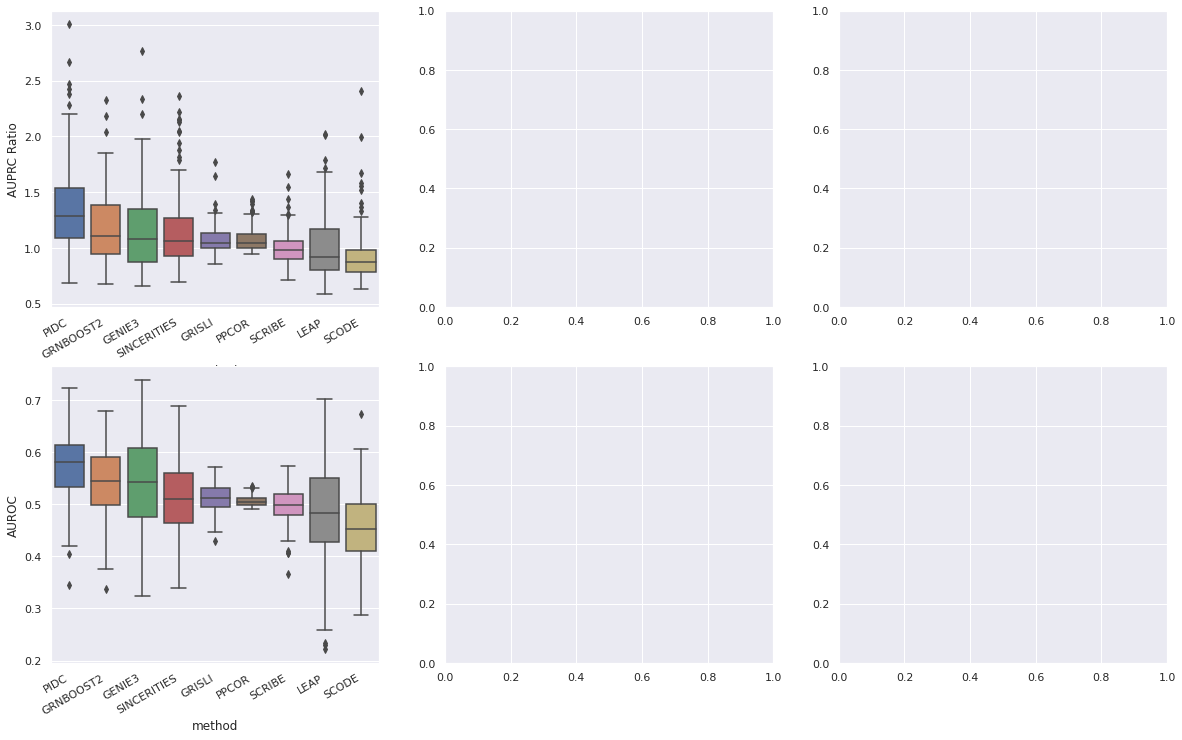

In [63]:
def plot_grn_main():
    fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(20, 12))
    
    for auc in ["PRC", "ROC"]:
        df_all = None
        is_roc = auc == "ROC"
        for tree in [1, 3, 5]:
            t = "" if tree == 1 else str(tree)
            a_0_500 = get_df2("unif", f"unif{t}_0-AU{auc}", roc=is_roc)
            a_1_500 = get_df2("unif", f"unif{t}_1-AU{auc}", roc=is_roc)
            a_0_800 = get_df2("unif", f"unif{t}_0_800-AU{auc}", roc=is_roc)
            a_1_800 = get_df2("unif", f"unif{t}_1_800-AU{auc}", roc=is_roc)
            df = pd.concat((a_0_500, a_1_500, a_0_800, a_1_800))
            df["tree"] = tree
            if df_all is None:
                df_all = df
            else:
                df_all = pd.concat((df_all, df))
        
        df = df_all
        df = df[df.method != "GRNVBEM"]
        df = df[df.method != "SINGE"]
        # return(df.groupby("ds").mean().sort_values(by="value"))
        order = df.groupby("method").mean().value.sort_values(ascending=False).index
        # for i, ngenes in [(0, 110), (1, 200), (2, 500)]:
            # pl = sns.boxplot(df[df.ngenes == ngenes], y="value", x="method", ax=axs[1 if is_roc else 0, i])
        # for i, tree in [(0, 1), (1, 3), (2, 5)]:
        #     pl = sns.boxplot(df[df.tree == tree], y="value", x="method", ax=axs[1 if is_roc else 0, i])
        
        pl = sns.boxplot(df_all, y="value", x="method", order=order, ax=axs[1 if is_roc else 0, 0])
        pl.set(ylabel=("AUROC" if is_roc else "AUPRC Ratio"))
        pl.set_xticklabels(pl.get_xticklabels(),rotation = 30, horizontalalignment='right')
        
    plt.savefig(f"unif_grn.pdf")
            
plot_grn_main()

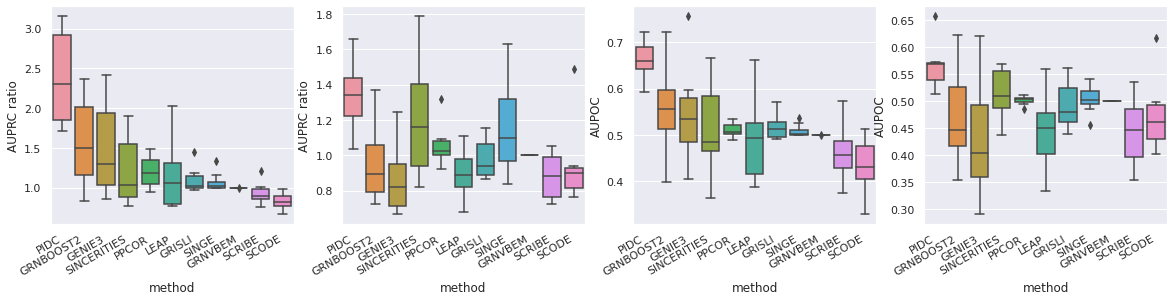

In [17]:
def plot_grn_aux(ds):
    fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 4))
    
    x, res = get_df(ds, "AUPRC_nonoise")
    a = sns.boxplot(x, y="value", x="method", order=res.columns, ax=axs[0])
    a.set(ylabel='AUPRC ratio')
    a.set_xticklabels(a.get_xticklabels(),rotation = 30, horizontalalignment='right')
    
    x, _ = get_df(ds, "GSD-AUPRC")
    a = sns.boxplot(x, y="value", x="method", order=res.columns, ax=axs[1])
    a.set(ylabel='AUPRC ratio')
    a.set_xticklabels(a.get_xticklabels(),rotation = 30, horizontalalignment='right')
    
    x, _ = get_df(ds, "AUROC_nonoise", roc=True)
    a = sns.boxplot(x, y="value", x="method", order=res.columns, ax=axs[2])
    a.set(ylabel='AUPOC')
    a.set_xticklabels(a.get_xticklabels(),rotation = 30, horizontalalignment='right')
    
    x, _ = get_df(ds, "GSD-AUROC", roc=True)
    a = sns.boxplot(x, y="value", x="method", order=res.columns, ax=axs[3])
    a.set(ylabel='AUPOC')
    a.set_xticklabels(a.get_xticklabels(),rotation = 30, horizontalalignment='right')
    
    plt.savefig(f"{ds}.pdf")

plot_grn_aux("scm2")